##### source code:
##### https://colab.research.google.com/drive/1ZZXnCjFEOkp_KdNcNabd14yok0BAIuwS#forceEdit=true&sandboxMode=true&scrollTo=J_o2L3Io9t4c

In [2]:
#Imports
import os
import numpy as np
import tensorflow as tf
keras = tf.keras
import matplotlib.pyplot as plt

In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# split the data manually into 80% training, 10% testing, 10% validation
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

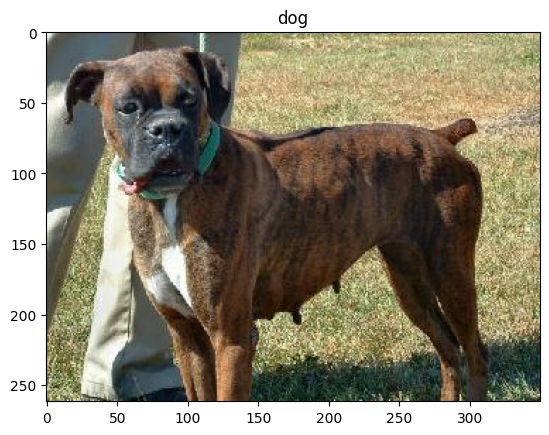

In [4]:
get_label_name = metadata.features['label'].int2str  # creates a function object that we can use to get labels

# display 2 images from the dataset
for image, label in raw_train.take(1):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [5]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  """
  returns an image that is reshaped to IMG_SIZE
  """
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [6]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

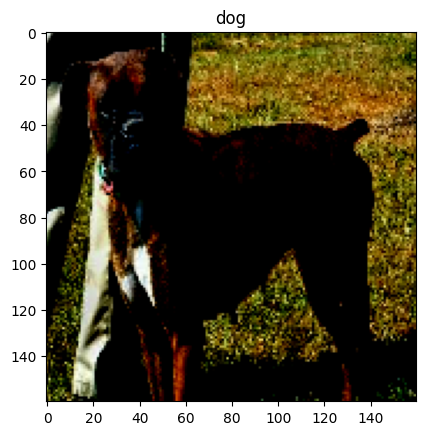

In [7]:
for image, label in train.take(1):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [8]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [9]:
for img, label in raw_train.take(1):
  print("Original shape:", img.shape)

for img, label in train.take(1):
  print("New shape:", img.shape)

Original shape: (262, 350, 3)
New shape: (160, 160, 3)


In [10]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 2s 0us/step


In [11]:
for image, _ in train_batches.take(1):
   pass

feature_batch = base_model(image)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [12]:
base_model.trainable = False

In [ ]:
# base_model.summary()

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [14]:
prediction_layer = keras.layers.Dense(1)

In [15]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# We can evaluate the model right now to see how it does before training it on our new images
initial_epochs = 3
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 3s 104ms/step - loss: 0.6281 - accuracy: 0.6094


In [20]:
# Now we can train it on our images
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

Epoch 1/3
582/582 [==============================] - 450s 764ms/step - loss: 0.0737 - accuracy: 0.9711 - val_loss: 0.0474 - val_accuracy: 0.9841
Epoch 2/3
582/582 [==============================] - 438s 750ms/step - loss: 0.0437 - accuracy: 0.9837 - val_loss: 0.0457 - val_accuracy: 0.9845
Epoch 3/3
582/582 [==============================] - 374s 641ms/step - loss: 0.0396 - accuracy: 0.9862 - val_loss: 0.0446 - val_accuracy: 0.9850
[0.9711445569992065, 0.9836646914482117, 0.9861901998519897]


In [19]:
model.save("dogs_vs_cats.h5")  # we can save the model and reload it at anytime in the future
dogVsCat_model = tf.keras.models.load_model('dogs_vs_cats.h5')

/Users/lal7/miniconda3/envs/py311/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
dogVsCat_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
